In [363]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn import metrics

import time
import os
import cv2

img_height = 64
img_width = 64
batch_size = 32

In [364]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='training_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 5064 files belonging to 2 classes.


In [365]:
val_ds = keras.utils.image_dataset_from_directory(
    directory='validation_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 967 files belonging to 2 classes.


In [366]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 564 files belonging to 2 classes.


In [367]:
all_ds = keras.utils.image_dataset_from_directory(
    directory='tiles/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 114216 files belonging to 2 classes.


In [368]:
class_names = train_ds.class_names
print(class_names)

['defect', 'normal']


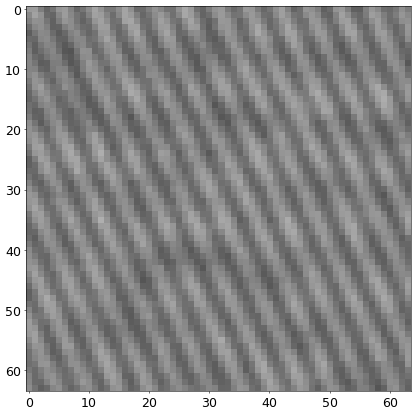

tf.Tensor(
[[[154. 154. 154.]
  [156. 156. 156.]
  [126. 126. 126.]
  ...
  [119. 119. 119.]
  [143. 143. 143.]
  [125. 125. 125.]]

 [[136. 136. 136.]
  [162. 162. 162.]
  [146. 146. 146.]
  ...
  [125. 125. 125.]
  [150. 150. 150.]
  [137. 137. 137.]]

 [[127. 127. 127.]
  [145. 145. 145.]
  [143. 143. 143.]
  ...
  [114. 114. 114.]
  [142. 142. 142.]
  [145. 145. 145.]]

 ...

 [[131. 131. 131.]
  [106. 106. 106.]
  [120. 120. 120.]
  ...
  [129. 129. 129.]
  [107. 107. 107.]
  [113. 113. 113.]]

 [[134. 134. 134.]
  [106. 106. 106.]
  [105. 105. 105.]
  ...
  [139. 139. 139.]
  [112. 112. 112.]
  [102. 102. 102.]]

 [[140. 140. 140.]
  [115. 115. 115.]
  [ 96.  96.  96.]
  ...
  [146. 146. 146.]
  [118. 118. 118.]
  [ 98.  98.  98.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


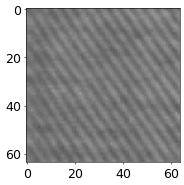

tf.Tensor(
[[[112. 112. 112.]
  [105. 105. 105.]
  [116. 116. 116.]
  ...
  [123. 123. 123.]
  [121. 121. 121.]
  [108. 108. 108.]]

 [[109. 109. 109.]
  [105. 105. 105.]
  [108. 108. 108.]
  ...
  [117. 117. 117.]
  [129. 129. 129.]
  [123. 123. 123.]]

 [[124. 124. 124.]
  [108. 108. 108.]
  [109. 109. 109.]
  ...
  [112. 112. 112.]
  [129. 129. 129.]
  [136. 136. 136.]]

 ...

 [[120. 120. 120.]
  [113. 113. 113.]
  [113. 113. 113.]
  ...
  [113. 113. 113.]
  [112. 112. 112.]
  [127. 127. 127.]]

 [[123. 123. 123.]
  [126. 126. 126.]
  [118. 118. 118.]
  ...
  [118. 118. 118.]
  [106. 106. 106.]
  [120. 120. 120.]]

 [[124. 124. 124.]
  [122. 122. 122.]
  [115. 115. 115.]
  ...
  [123. 123. 123.]
  [120. 120. 120.]
  [112. 112. 112.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


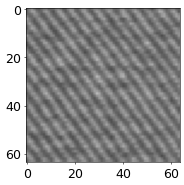

tf.Tensor(
[[[ 99.  99.  99.]
  [128. 128. 128.]
  [144. 144. 144.]
  ...
  [128. 128. 128.]
  [104. 104. 104.]
  [ 94.  94.  94.]]

 [[ 99.  99.  99.]
  [126. 126. 126.]
  [158. 158. 158.]
  ...
  [162. 162. 162.]
  [130. 130. 130.]
  [ 90.  90.  90.]]

 [[101. 101. 101.]
  [105. 105. 105.]
  [118. 118. 118.]
  ...
  [139. 139. 139.]
  [159. 159. 159.]
  [133. 133. 133.]]

 ...

 [[150. 150. 150.]
  [149. 149. 149.]
  [123. 123. 123.]
  ...
  [102. 102. 102.]
  [104. 104. 104.]
  [138. 138. 138.]]

 [[118. 118. 118.]
  [147. 147. 147.]
  [148. 148. 148.]
  ...
  [129. 129. 129.]
  [105. 105. 105.]
  [105. 105. 105.]]

 [[ 96.  96.  96.]
  [127. 127. 127.]
  [136. 136. 136.]
  ...
  [142. 142. 142.]
  [116. 116. 116.]
  [ 94.  94.  94.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


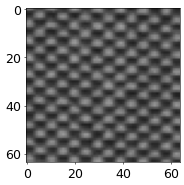

tf.Tensor(
[[[117. 117. 117.]
  [117. 117. 117.]
  [105. 105. 105.]
  ...
  [ 48.  48.  48.]
  [ 38.  38.  38.]
  [ 36.  36.  36.]]

 [[ 48.  48.  48.]
  [ 53.  53.  53.]
  [ 53.  53.  53.]
  ...
  [ 54.  54.  54.]
  [ 47.  47.  47.]
  [ 48.  48.  48.]]

 [[ 35.  35.  35.]
  [ 35.  35.  35.]
  [ 47.  47.  47.]
  ...
  [ 65.  65.  65.]
  [ 63.  63.  63.]
  [ 61.  61.  61.]]

 ...

 [[115. 115. 115.]
  [125. 125. 125.]
  [104. 104. 104.]
  ...
  [126. 126. 126.]
  [133. 133. 133.]
  [131. 131. 131.]]

 [[134. 134. 134.]
  [145. 145. 145.]
  [132. 132. 132.]
  ...
  [ 85.  85.  85.]
  [ 96.  96.  96.]
  [ 99.  99.  99.]]

 [[119. 119. 119.]
  [121. 121. 121.]
  [116. 116. 116.]
  ...
  [ 51.  51.  51.]
  [ 41.  41.  41.]
  [ 43.  43.  43.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


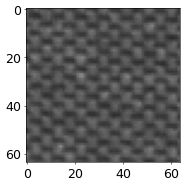

tf.Tensor(
[[[ 75.  75.  75.]
  [ 73.  73.  73.]
  [ 78.  78.  78.]
  ...
  [101. 101. 101.]
  [ 79.  79.  79.]
  [ 63.  63.  63.]]

 [[ 91.  91.  91.]
  [ 74.  74.  74.]
  [ 65.  65.  65.]
  ...
  [ 95.  95.  95.]
  [ 73.  73.  73.]
  [ 56.  56.  56.]]

 [[ 85.  85.  85.]
  [ 64.  64.  64.]
  [ 57.  57.  57.]
  ...
  [ 84.  84.  84.]
  [ 66.  66.  66.]
  [ 61.  61.  61.]]

 ...

 [[110. 110. 110.]
  [ 83.  83.  83.]
  [ 68.  68.  68.]
  ...
  [109. 109. 109.]
  [ 96.  96.  96.]
  [ 85.  85.  85.]]

 [[ 98.  98.  98.]
  [ 78.  78.  78.]
  [ 65.  65.  65.]
  ...
  [ 81.  81.  81.]
  [ 84.  84.  84.]
  [103. 103. 103.]]

 [[ 86.  86.  86.]
  [ 86.  86.  86.]
  [ 86.  86.  86.]
  ...
  [ 60.  60.  60.]
  [ 64.  64.  64.]
  [ 78.  78.  78.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


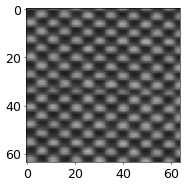

tf.Tensor(
[[[ 67.  67.  67.]
  [ 68.  68.  68.]
  [ 65.  65.  65.]
  ...
  [ 95.  95.  95.]
  [ 61.  61.  61.]
  [ 42.  42.  42.]]

 [[ 40.  40.  40.]
  [ 29.  29.  29.]
  [ 32.  32.  32.]
  ...
  [ 59.  59.  59.]
  [ 57.  57.  57.]
  [ 58.  58.  58.]]

 [[ 46.  46.  46.]
  [ 38.  38.  38.]
  [ 45.  45.  45.]
  ...
  [ 53.  53.  53.]
  [ 90.  90.  90.]
  [117. 117. 117.]]

 ...

 [[ 96.  96.  96.]
  [106. 106. 106.]
  [100. 100. 100.]
  ...
  [ 62.  62.  62.]
  [ 99.  99.  99.]
  [115. 115. 115.]]

 [[133. 133. 133.]
  [150. 150. 150.]
  [142. 142. 142.]
  ...
  [ 72.  72.  72.]
  [ 53.  53.  53.]
  [ 43.  43.  43.]]

 [[125. 125. 125.]
  [140. 140. 140.]
  [137. 137. 137.]
  ...
  [ 98.  98.  98.]
  [ 52.  52.  52.]
  [ 34.  34.  34.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


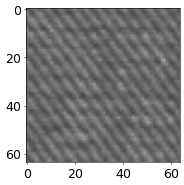

tf.Tensor(
[[[ 95.  95.  95.]
  [ 87.  87.  87.]
  [114. 114. 114.]
  ...
  [112. 112. 112.]
  [104. 104. 104.]
  [ 86.  86.  86.]]

 [[127. 127. 127.]
  [ 93.  93.  93.]
  [ 80.  80.  80.]
  ...
  [ 98.  98.  98.]
  [ 96.  96.  96.]
  [ 79.  79.  79.]]

 [[140. 140. 140.]
  [101. 101. 101.]
  [ 86.  86.  86.]
  ...
  [ 89.  89.  89.]
  [100. 100. 100.]
  [ 98.  98.  98.]]

 ...

 [[ 93.  93.  93.]
  [ 98.  98.  98.]
  [126. 126. 126.]
  ...
  [127. 127. 127.]
  [104. 104. 104.]
  [ 93.  93.  93.]]

 [[ 89.  89.  89.]
  [ 85.  85.  85.]
  [104. 104. 104.]
  ...
  [112. 112. 112.]
  [107. 107. 107.]
  [ 96.  96.  96.]]

 [[100. 100. 100.]
  [ 81.  81.  81.]
  [ 77.  77.  77.]
  ...
  [109. 109. 109.]
  [122. 122. 122.]
  [104. 104. 104.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


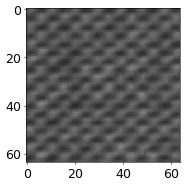

tf.Tensor(
[[[ 86.  86.  86.]
  [ 99.  99.  99.]
  [108. 108. 108.]
  ...
  [ 56.  56.  56.]
  [ 50.  50.  50.]
  [ 54.  54.  54.]]

 [[ 86.  86.  86.]
  [ 95.  95.  95.]
  [ 91.  91.  91.]
  ...
  [ 62.  62.  62.]
  [ 62.  62.  62.]
  [ 70.  70.  70.]]

 [[ 82.  82.  82.]
  [ 83.  83.  83.]
  [ 74.  74.  74.]
  ...
  [ 91.  91.  91.]
  [ 97.  97.  97.]
  [ 91.  91.  91.]]

 ...

 [[ 69.  69.  69.]
  [ 52.  52.  52.]
  [ 60.  60.  60.]
  ...
  [115. 115. 115.]
  [112. 112. 112.]
  [101. 101. 101.]]

 [[ 47.  47.  47.]
  [ 50.  50.  50.]
  [ 57.  57.  57.]
  ...
  [ 91.  91.  91.]
  [ 93.  93.  93.]
  [ 87.  87.  87.]]

 [[ 61.  61.  61.]
  [ 66.  66.  66.]
  [ 76.  76.  76.]
  ...
  [ 83.  83.  83.]
  [ 80.  80.  80.]
  [ 72.  72.  72.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


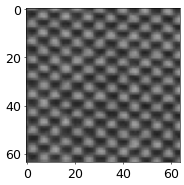

tf.Tensor(
[[[ 97.  97.  97.]
  [117. 117. 117.]
  [118. 118. 118.]
  ...
  [ 61.  61.  61.]
  [ 44.  44.  44.]
  [ 44.  44.  44.]]

 [[ 58.  58.  58.]
  [ 52.  52.  52.]
  [ 47.  47.  47.]
  ...
  [ 79.  79.  79.]
  [ 57.  57.  57.]
  [ 57.  57.  57.]]

 [[ 57.  57.  57.]
  [ 43.  43.  43.]
  [ 35.  35.  35.]
  ...
  [ 92.  92.  92.]
  [ 75.  75.  75.]
  [ 86.  86.  86.]]

 ...

 [[ 72.  72.  72.]
  [ 46.  46.  46.]
  [ 40.  40.  40.]
  ...
  [ 88.  88.  88.]
  [ 66.  66.  66.]
  [ 68.  68.  68.]]

 [[ 87.  87.  87.]
  [ 55.  55.  55.]
  [ 41.  41.  41.]
  ...
  [ 67.  67.  67.]
  [ 77.  77.  77.]
  [ 99.  99.  99.]]

 [[ 70.  70.  70.]
  [ 71.  71.  71.]
  [ 69.  69.  69.]
  ...
  [ 61.  61.  61.]
  [ 98.  98.  98.]
  [127. 127. 127.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


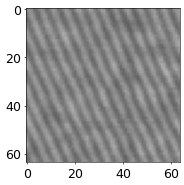

tf.Tensor(
[[[140. 140. 140.]
  [149. 149. 149.]
  [139. 139. 139.]
  ...
  [145. 145. 145.]
  [147. 147. 147.]
  [151. 151. 151.]]

 [[130. 130. 130.]
  [149. 149. 149.]
  [141. 141. 141.]
  ...
  [129. 129. 129.]
  [150. 150. 150.]
  [153. 153. 153.]]

 [[119. 119. 119.]
  [142. 142. 142.]
  [148. 148. 148.]
  ...
  [111. 111. 111.]
  [139. 139. 139.]
  [158. 158. 158.]]

 ...

 [[104. 104. 104.]
  [127. 127. 127.]
  [141. 141. 141.]
  ...
  [126. 126. 126.]
  [143. 143. 143.]
  [156. 156. 156.]]

 [[102. 102. 102.]
  [115. 115. 115.]
  [143. 143. 143.]
  ...
  [116. 116. 116.]
  [122. 122. 122.]
  [144. 144. 144.]]

 [[107. 107. 107.]
  [111. 111. 111.]
  [137. 137. 137.]
  ...
  [113. 113. 113.]
  [118. 118. 118.]
  [141. 141. 141.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


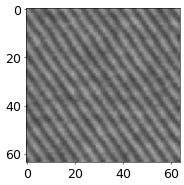

tf.Tensor(
[[[145. 145. 145.]
  [118. 118. 118.]
  [ 83.  83.  83.]
  ...
  [113. 113. 113.]
  [166. 166. 166.]
  [152. 152. 152.]]

 [[138. 138. 138.]
  [131. 131. 131.]
  [ 92.  92.  92.]
  ...
  [ 91.  91.  91.]
  [122. 122. 122.]
  [150. 150. 150.]]

 [[128. 128. 128.]
  [145. 145. 145.]
  [129. 129. 129.]
  ...
  [ 79.  79.  79.]
  [ 80.  80.  80.]
  [136. 136. 136.]]

 ...

 [[136. 136. 136.]
  [143. 143. 143.]
  [130. 130. 130.]
  ...
  [ 82.  82.  82.]
  [ 90.  90.  90.]
  [145. 145. 145.]]

 [[ 88.  88.  88.]
  [124. 124. 124.]
  [141. 141. 141.]
  ...
  [ 87.  87.  87.]
  [ 78.  78.  78.]
  [108. 108. 108.]]

 [[ 69.  69.  69.]
  [111. 111. 111.]
  [137. 137. 137.]
  ...
  [108. 108. 108.]
  [ 82.  82.  82.]
  [ 70.  70.  70.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


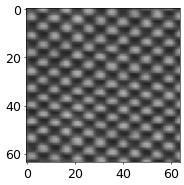

tf.Tensor(
[[[ 84.  84.  84.]
  [ 79.  79.  79.]
  [ 69.  69.  69.]
  ...
  [ 80.  80.  80.]
  [ 62.  62.  62.]
  [ 60.  60.  60.]]

 [[ 83.  83.  83.]
  [ 97.  97.  97.]
  [ 95.  95.  95.]
  ...
  [ 61.  61.  61.]
  [ 79.  79.  79.]
  [ 87.  87.  87.]]

 [[102. 102. 102.]
  [129. 129. 129.]
  [136. 136. 136.]
  ...
  [ 66.  66.  66.]
  [118. 118. 118.]
  [144. 144. 144.]]

 ...

 [[117. 117. 117.]
  [149. 149. 149.]
  [157. 157. 157.]
  ...
  [ 74.  74.  74.]
  [122. 122. 122.]
  [157. 157. 157.]]

 [[116. 116. 116.]
  [128. 128. 128.]
  [133. 133. 133.]
  ...
  [ 78.  78.  78.]
  [ 98.  98.  98.]
  [136. 136. 136.]]

 [[ 72.  72.  72.]
  [ 60.  60.  60.]
  [ 57.  57.  57.]
  ...
  [ 76.  76.  76.]
  [ 60.  60.  60.]
  [ 68.  68.  68.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


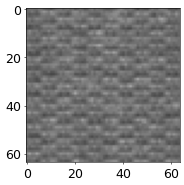

tf.Tensor(
[[[ 98.  98.  98.]
  [110. 110. 110.]
  [107. 107. 107.]
  ...
  [ 88.  88.  88.]
  [ 80.  80.  80.]
  [ 94.  94.  94.]]

 [[104. 104. 104.]
  [105. 105. 105.]
  [121. 121. 121.]
  ...
  [103. 103. 103.]
  [124. 124. 124.]
  [115. 115. 115.]]

 [[100. 100. 100.]
  [ 86.  86.  86.]
  [ 94.  94.  94.]
  ...
  [121. 121. 121.]
  [146. 146. 146.]
  [124. 124. 124.]]

 ...

 [[111. 111. 111.]
  [121. 121. 121.]
  [112. 112. 112.]
  ...
  [ 92.  92.  92.]
  [ 87.  87.  87.]
  [ 90.  90.  90.]]

 [[120. 120. 120.]
  [114. 114. 114.]
  [118. 118. 118.]
  ...
  [106. 106. 106.]
  [ 98.  98.  98.]
  [104. 104. 104.]]

 [[ 97.  97.  97.]
  [ 96.  96.  96.]
  [104. 104. 104.]
  ...
  [134. 134. 134.]
  [133. 133. 133.]
  [119. 119. 119.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


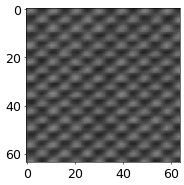

tf.Tensor(
[[[103. 103. 103.]
  [119. 119. 119.]
  [116. 116. 116.]
  ...
  [ 71.  71.  71.]
  [ 49.  49.  49.]
  [ 39.  39.  39.]]

 [[114. 114. 114.]
  [123. 123. 123.]
  [116. 116. 116.]
  ...
  [ 77.  77.  77.]
  [ 59.  59.  59.]
  [ 51.  51.  51.]]

 [[ 95.  95.  95.]
  [ 86.  86.  86.]
  [ 82.  82.  82.]
  ...
  [ 68.  68.  68.]
  [ 71.  71.  71.]
  [ 74.  74.  74.]]

 ...

 [[ 76.  76.  76.]
  [ 74.  74.  74.]
  [ 75.  75.  75.]
  ...
  [ 89.  89.  89.]
  [101. 101. 101.]
  [103. 103. 103.]]

 [[ 82.  82.  82.]
  [ 94.  94.  94.]
  [ 98.  98.  98.]
  ...
  [ 68.  68.  68.]
  [ 59.  59.  59.]
  [ 51.  51.  51.]]

 [[101. 101. 101.]
  [119. 119. 119.]
  [121. 121. 121.]
  ...
  [ 66.  66.  66.]
  [ 48.  48.  48.]
  [ 47.  47.  47.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


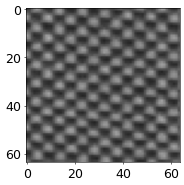

tf.Tensor(
[[[ 56.  56.  56.]
  [ 65.  65.  65.]
  [100. 100. 100.]
  ...
  [ 50.  50.  50.]
  [ 53.  53.  53.]
  [ 83.  83.  83.]]

 [[ 81.  81.  81.]
  [ 74.  74.  74.]
  [101. 101. 101.]
  ...
  [ 74.  74.  74.]
  [ 80.  80.  80.]
  [ 97.  97.  97.]]

 [[114. 114. 114.]
  [ 89.  89.  89.]
  [ 64.  64.  64.]
  ...
  [108. 108. 108.]
  [110. 110. 110.]
  [ 94.  94.  94.]]

 ...

 [[ 63.  63.  63.]
  [ 60.  60.  60.]
  [ 86.  86.  86.]
  ...
  [ 49.  49.  49.]
  [ 51.  51.  51.]
  [ 68.  68.  68.]]

 [[ 89.  89.  89.]
  [ 78.  78.  78.]
  [ 94.  94.  94.]
  ...
  [ 74.  74.  74.]
  [ 75.  75.  75.]
  [ 84.  84.  84.]]

 [[126. 126. 126.]
  [ 96.  96.  96.]
  [ 68.  68.  68.]
  ...
  [107. 107. 107.]
  [112. 112. 112.]
  [104. 104. 104.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


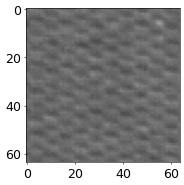

tf.Tensor(
[[[117. 117. 117.]
  [127. 127. 127.]
  [129. 129. 129.]
  ...
  [110. 110. 110.]
  [105. 105. 105.]
  [110. 110. 110.]]

 [[111. 111. 111.]
  [114. 114. 114.]
  [115. 115. 115.]
  ...
  [ 97.  97.  97.]
  [ 99.  99.  99.]
  [104. 104. 104.]]

 [[118. 118. 118.]
  [109. 109. 109.]
  [107. 107. 107.]
  ...
  [102. 102. 102.]
  [ 95.  95.  95.]
  [ 97.  97.  97.]]

 ...

 [[ 99.  99.  99.]
  [ 99.  99.  99.]
  [101. 101. 101.]
  ...
  [ 88.  88.  88.]
  [ 90.  90.  90.]
  [ 96.  96.  96.]]

 [[111. 111. 111.]
  [101. 101. 101.]
  [ 95.  95.  95.]
  ...
  [114. 114. 114.]
  [110. 110. 110.]
  [ 97.  97.  97.]]

 [[109. 109. 109.]
  [105. 105. 105.]
  [ 94.  94.  94.]
  ...
  [122. 122. 122.]
  [116. 116. 116.]
  [104. 104. 104.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


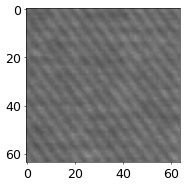

tf.Tensor(
[[[108. 108. 108.]
  [108. 108. 108.]
  [102. 102. 102.]
  ...
  [121. 121. 121.]
  [130. 130. 130.]
  [116. 116. 116.]]

 [[101. 101. 101.]
  [110. 110. 110.]
  [100. 100. 100.]
  ...
  [110. 110. 110.]
  [121. 121. 121.]
  [118. 118. 118.]]

 [[ 93.  93.  93.]
  [ 95.  95.  95.]
  [104. 104. 104.]
  ...
  [ 93.  93.  93.]
  [109. 109. 109.]
  [119. 119. 119.]]

 ...

 [[118. 118. 118.]
  [110. 110. 110.]
  [100. 100. 100.]
  ...
  [139. 139. 139.]
  [123. 123. 123.]
  [116. 116. 116.]]

 [[120. 120. 120.]
  [113. 113. 113.]
  [102. 102. 102.]
  ...
  [143. 143. 143.]
  [141. 141. 141.]
  [115. 115. 115.]]

 [[107. 107. 107.]
  [119. 119. 119.]
  [105. 105. 105.]
  ...
  [115. 115. 115.]
  [123. 123. 123.]
  [124. 124. 124.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


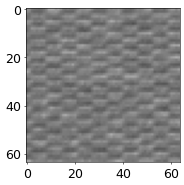

tf.Tensor(
[[[146. 146. 146.]
  [142. 142. 142.]
  [118. 118. 118.]
  ...
  [153. 153. 153.]
  [136. 136. 136.]
  [153. 153. 153.]]

 [[137. 137. 137.]
  [132. 132. 132.]
  [108. 108. 108.]
  ...
  [128. 128. 128.]
  [122. 122. 122.]
  [129. 129. 129.]]

 [[121. 121. 121.]
  [115. 115. 115.]
  [123. 123. 123.]
  ...
  [126. 126. 126.]
  [128. 128. 128.]
  [125. 125. 125.]]

 ...

 [[ 98.  98.  98.]
  [100. 100. 100.]
  [112. 112. 112.]
  ...
  [109. 109. 109.]
  [103. 103. 103.]
  [ 98.  98.  98.]]

 [[104. 104. 104.]
  [113. 113. 113.]
  [110. 110. 110.]
  ...
  [133. 133. 133.]
  [132. 132. 132.]
  [124. 124. 124.]]

 [[165. 165. 165.]
  [164. 164. 164.]
  [138. 138. 138.]
  ...
  [147. 147. 147.]
  [144. 144. 144.]
  [148. 148. 148.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


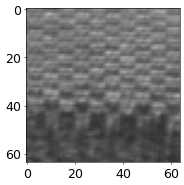

tf.Tensor(
[[[115. 115. 115.]
  [128. 128. 128.]
  [136. 136. 136.]
  ...
  [124. 124. 124.]
  [130. 130. 130.]
  [122. 122. 122.]]

 [[124. 124. 124.]
  [116. 116. 116.]
  [114. 114. 114.]
  ...
  [118. 118. 118.]
  [129. 129. 129.]
  [113. 113. 113.]]

 [[147. 147. 147.]
  [123. 123. 123.]
  [120. 120. 120.]
  ...
  [113. 113. 113.]
  [112. 112. 112.]
  [106. 106. 106.]]

 ...

 [[ 88.  88.  88.]
  [ 85.  85.  85.]
  [ 76.  76.  76.]
  ...
  [ 51.  51.  51.]
  [ 60.  60.  60.]
  [ 60.  60.  60.]]

 [[ 76.  76.  76.]
  [ 66.  66.  66.]
  [ 58.  58.  58.]
  ...
  [ 50.  50.  50.]
  [ 59.  59.  59.]
  [ 57.  57.  57.]]

 [[ 77.  77.  77.]
  [ 80.  80.  80.]
  [ 69.  69.  69.]
  ...
  [ 49.  49.  49.]
  [ 54.  54.  54.]
  [ 59.  59.  59.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


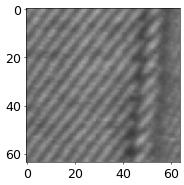

tf.Tensor(
[[[117. 117. 117.]
  [144. 144. 144.]
  [142. 142. 142.]
  ...
  [103. 103. 103.]
  [110. 110. 110.]
  [113. 113. 113.]]

 [[123. 123. 123.]
  [129. 129. 129.]
  [119. 119. 119.]
  ...
  [ 99.  99.  99.]
  [108. 108. 108.]
  [110. 110. 110.]]

 [[140. 140. 140.]
  [124. 124. 124.]
  [101. 101. 101.]
  ...
  [ 98.  98.  98.]
  [ 98.  98.  98.]
  [106. 106. 106.]]

 ...

 [[117. 117. 117.]
  [ 99.  99.  99.]
  [106. 106. 106.]
  ...
  [127. 127. 127.]
  [103. 103. 103.]
  [ 95.  95.  95.]]

 [[105. 105. 105.]
  [106. 106. 106.]
  [125. 125. 125.]
  ...
  [117. 117. 117.]
  [106. 106. 106.]
  [111. 111. 111.]]

 [[100. 100. 100.]
  [109. 109. 109.]
  [121. 121. 121.]
  ...
  [115. 115. 115.]
  [118. 118. 118.]
  [120. 120. 120.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


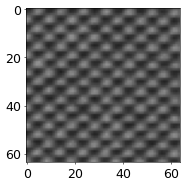

tf.Tensor(
[[[ 44.  44.  44.]
  [ 39.  39.  39.]
  [ 58.  58.  58.]
  ...
  [ 98.  98.  98.]
  [100. 100. 100.]
  [ 95.  95.  95.]]

 [[ 51.  51.  51.]
  [ 59.  59.  59.]
  [ 74.  74.  74.]
  ...
  [127. 127. 127.]
  [128. 128. 128.]
  [104. 104. 104.]]

 [[ 75.  75.  75.]
  [ 80.  80.  80.]
  [ 92.  92.  92.]
  ...
  [137. 137. 137.]
  [127. 127. 127.]
  [106. 106. 106.]]

 ...

 [[ 83.  83.  83.]
  [ 86.  86.  86.]
  [ 93.  93.  93.]
  ...
  [130. 130. 130.]
  [122. 122. 122.]
  [100. 100. 100.]]

 [[118. 118. 118.]
  [ 98.  98.  98.]
  [ 75.  75.  75.]
  ...
  [ 65.  65.  65.]
  [ 67.  67.  67.]
  [ 72.  72.  72.]]

 [[131. 131. 131.]
  [107. 107. 107.]
  [ 75.  75.  75.]
  ...
  [ 39.  39.  39.]
  [ 43.  43.  43.]
  [ 64.  64.  64.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


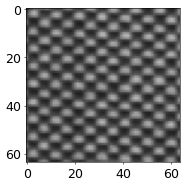

tf.Tensor(
[[[ 46.  46.  46.]
  [ 70.  70.  70.]
  [ 90.  90.  90.]
  ...
  [ 39.  39.  39.]
  [ 64.  64.  64.]
  [124. 124. 124.]]

 [[ 61.  61.  61.]
  [113. 113. 113.]
  [149. 149. 149.]
  ...
  [ 51.  51.  51.]
  [ 86.  86.  86.]
  [137. 137. 137.]]

 [[ 76.  76.  76.]
  [128. 128. 128.]
  [161. 161. 161.]
  ...
  [ 76.  76.  76.]
  [ 89.  89.  89.]
  [125. 125. 125.]]

 ...

 [[ 88.  88.  88.]
  [120. 120. 120.]
  [138. 138. 138.]
  ...
  [ 84.  84.  84.]
  [ 68.  68.  68.]
  [ 74.  74.  74.]]

 [[ 66.  66.  66.]
  [ 57.  57.  57.]
  [ 57.  57.  57.]
  ...
  [122. 122. 122.]
  [ 66.  66.  66.]
  [ 41.  41.  41.]]

 [[ 86.  86.  86.]
  [ 42.  42.  42.]
  [ 32.  32.  32.]
  ...
  [128. 128. 128.]
  [ 82.  82.  82.]
  [ 45.  45.  45.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


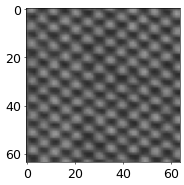

tf.Tensor(
[[[107. 107. 107.]
  [139. 139. 139.]
  [149. 149. 149.]
  ...
  [ 93.  93.  93.]
  [ 99.  99.  99.]
  [ 94.  94.  94.]]

 [[107. 107. 107.]
  [130. 130. 130.]
  [132. 132. 132.]
  ...
  [123. 123. 123.]
  [144. 144. 144.]
  [132. 132. 132.]]

 [[ 78.  78.  78.]
  [ 73.  73.  73.]
  [ 75.  75.  75.]
  ...
  [126. 126. 126.]
  [157. 157. 157.]
  [144. 144. 144.]]

 ...

 [[ 69.  69.  69.]
  [ 54.  54.  54.]
  [ 57.  57.  57.]
  ...
  [ 98.  98.  98.]
  [125. 125. 125.]
  [127. 127. 127.]]

 [[ 84.  84.  84.]
  [ 57.  57.  57.]
  [ 45.  45.  45.]
  ...
  [ 74.  74.  74.]
  [ 88.  88.  88.]
  [101. 101. 101.]]

 [[ 82.  82.  82.]
  [ 67.  67.  67.]
  [ 54.  54.  54.]
  ...
  [ 64.  64.  64.]
  [ 47.  47.  47.]
  [ 47.  47.  47.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


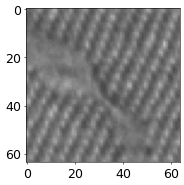

tf.Tensor(
[[[116. 116. 116.]
  [104. 104. 104.]
  [108. 108. 108.]
  ...
  [125. 125. 125.]
  [130. 130. 130.]
  [134. 134. 134.]]

 [[106. 106. 106.]
  [ 94.  94.  94.]
  [111. 111. 111.]
  ...
  [132. 132. 132.]
  [135. 135. 135.]
  [138. 138. 138.]]

 [[ 97.  97.  97.]
  [ 91.  91.  91.]
  [105. 105. 105.]
  ...
  [143. 143. 143.]
  [145. 145. 145.]
  [134. 134. 134.]]

 ...

 [[118. 118. 118.]
  [141. 141. 141.]
  [146. 146. 146.]
  ...
  [109. 109. 109.]
  [101. 101. 101.]
  [108. 108. 108.]]

 [[126. 126. 126.]
  [140. 140. 140.]
  [148. 148. 148.]
  ...
  [114. 114. 114.]
  [ 98.  98.  98.]
  [106. 106. 106.]]

 [[122. 122. 122.]
  [117. 117. 117.]
  [119. 119. 119.]
  ...
  [114. 114. 114.]
  [ 98.  98.  98.]
  [102. 102. 102.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


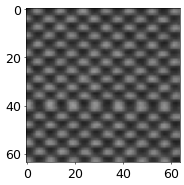

tf.Tensor(
[[[ 32.  32.  32.]
  [ 45.  45.  45.]
  [ 76.  76.  76.]
  ...
  [124. 124. 124.]
  [116. 116. 116.]
  [107. 107. 107.]]

 [[ 48.  48.  48.]
  [ 62.  62.  62.]
  [ 83.  83.  83.]
  ...
  [138. 138. 138.]
  [131. 131. 131.]
  [115. 115. 115.]]

 [[ 64.  64.  64.]
  [ 62.  62.  62.]
  [ 69.  69.  69.]
  ...
  [103. 103. 103.]
  [104. 104. 104.]
  [ 95.  95.  95.]]

 ...

 [[ 71.  71.  71.]
  [ 71.  71.  71.]
  [ 66.  66.  66.]
  ...
  [ 86.  86.  86.]
  [ 79.  79.  79.]
  [ 71.  71.  71.]]

 [[130. 130. 130.]
  [115. 115. 115.]
  [ 94.  94.  94.]
  ...
  [ 36.  36.  36.]
  [ 34.  34.  34.]
  [ 37.  37.  37.]]

 [[140. 140. 140.]
  [139. 139. 139.]
  [106. 106. 106.]
  ...
  [ 41.  41.  41.]
  [ 36.  36.  36.]
  [ 41.  41.  41.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


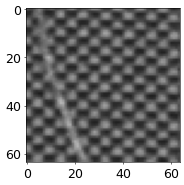

tf.Tensor(
[[[ 85.  85.  85.]
  [ 73.  73.  73.]
  [ 72.  72.  72.]
  ...
  [ 45.  45.  45.]
  [ 52.  52.  52.]
  [ 61.  61.  61.]]

 [[ 43.  43.  43.]
  [ 41.  41.  41.]
  [ 56.  56.  56.]
  ...
  [ 75.  75.  75.]
  [ 75.  75.  75.]
  [ 79.  79.  79.]]

 [[ 40.  40.  40.]
  [ 44.  44.  44.]
  [ 67.  67.  67.]
  ...
  [ 94.  94.  94.]
  [ 90.  90.  90.]
  [ 78.  78.  78.]]

 ...

 [[ 45.  45.  45.]
  [ 41.  41.  41.]
  [ 72.  72.  72.]
  ...
  [ 89.  89.  89.]
  [ 74.  74.  74.]
  [ 71.  71.  71.]]

 [[ 52.  52.  52.]
  [ 51.  51.  51.]
  [ 80.  80.  80.]
  ...
  [111. 111. 111.]
  [ 85.  85.  85.]
  [ 68.  68.  68.]]

 [[ 82.  82.  82.]
  [ 80.  80.  80.]
  [ 94.  94.  94.]
  ...
  [130. 130. 130.]
  [118. 118. 118.]
  [ 73.  73.  73.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


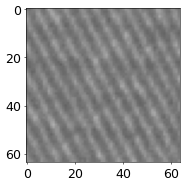

tf.Tensor(
[[[116. 116. 116.]
  [111. 111. 111.]
  [122. 122. 122.]
  ...
  [142. 142. 142.]
  [129. 129. 129.]
  [118. 118. 118.]]

 [[134. 134. 134.]
  [121. 121. 121.]
  [124. 124. 124.]
  ...
  [142. 142. 142.]
  [143. 143. 143.]
  [121. 121. 121.]]

 [[141. 141. 141.]
  [123. 123. 123.]
  [121. 121. 121.]
  ...
  [144. 144. 144.]
  [149. 149. 149.]
  [125. 125. 125.]]

 ...

 [[144. 144. 144.]
  [122. 122. 122.]
  [115. 115. 115.]
  ...
  [132. 132. 132.]
  [136. 136. 136.]
  [124. 124. 124.]]

 [[146. 146. 146.]
  [132. 132. 132.]
  [120. 120. 120.]
  ...
  [123. 123. 123.]
  [128. 128. 128.]
  [124. 124. 124.]]

 [[139. 139. 139.]
  [140. 140. 140.]
  [133. 133. 133.]
  ...
  [123. 123. 123.]
  [121. 121. 121.]
  [140. 140. 140.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


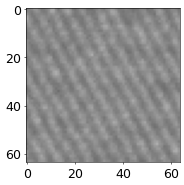

tf.Tensor(
[[[126. 126. 126.]
  [131. 131. 131.]
  [136. 136. 136.]
  ...
  [137. 137. 137.]
  [131. 131. 131.]
  [118. 118. 118.]]

 [[131. 131. 131.]
  [129. 129. 129.]
  [125. 125. 125.]
  ...
  [139. 139. 139.]
  [141. 141. 141.]
  [124. 124. 124.]]

 [[145. 145. 145.]
  [132. 132. 132.]
  [120. 120. 120.]
  ...
  [148. 148. 148.]
  [151. 151. 151.]
  [131. 131. 131.]]

 ...

 [[146. 146. 146.]
  [128. 128. 128.]
  [125. 125. 125.]
  ...
  [134. 134. 134.]
  [139. 139. 139.]
  [146. 146. 146.]]

 [[132. 132. 132.]
  [129. 129. 129.]
  [127. 127. 127.]
  ...
  [129. 129. 129.]
  [135. 135. 135.]
  [141. 141. 141.]]

 [[137. 137. 137.]
  [143. 143. 143.]
  [138. 138. 138.]
  ...
  [118. 118. 118.]
  [131. 131. 131.]
  [141. 141. 141.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


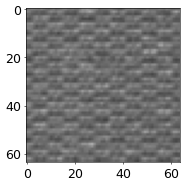

tf.Tensor(
[[[116. 116. 116.]
  [120. 120. 120.]
  [123. 123. 123.]
  ...
  [105. 105. 105.]
  [108. 108. 108.]
  [109. 109. 109.]]

 [[130. 130. 130.]
  [124. 124. 124.]
  [107. 107. 107.]
  ...
  [144. 144. 144.]
  [160. 160. 160.]
  [138. 138. 138.]]

 [[105. 105. 105.]
  [106. 106. 106.]
  [ 91.  91.  91.]
  ...
  [114. 114. 114.]
  [117. 117. 117.]
  [101. 101. 101.]]

 ...

 [[114. 114. 114.]
  [106. 106. 106.]
  [105. 105. 105.]
  ...
  [ 92.  92.  92.]
  [ 83.  83.  83.]
  [ 83.  83.  83.]]

 [[144. 144. 144.]
  [148. 148. 148.]
  [123. 123. 123.]
  ...
  [118. 118. 118.]
  [132. 132. 132.]
  [123. 123. 123.]]

 [[111. 111. 111.]
  [112. 112. 112.]
  [104. 104. 104.]
  ...
  [107. 107. 107.]
  [108. 108. 108.]
  [ 93.  93.  93.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


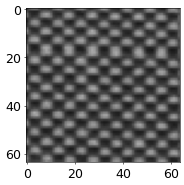

tf.Tensor(
[[[ 55.  55.  55.]
  [ 86.  86.  86.]
  [ 97.  97.  97.]
  ...
  [148. 148. 148.]
  [127. 127. 127.]
  [ 95.  95.  95.]]

 [[ 75.  75.  75.]
  [ 43.  43.  43.]
  [ 37.  37.  37.]
  ...
  [118. 118. 118.]
  [124. 124. 124.]
  [102. 102. 102.]]

 [[107. 107. 107.]
  [ 60.  60.  60.]
  [ 39.  39.  39.]
  ...
  [ 46.  46.  46.]
  [ 56.  56.  56.]
  [ 72.  72.  72.]]

 ...

 [[106. 106. 106.]
  [ 65.  65.  65.]
  [ 39.  39.  39.]
  ...
  [104. 104. 104.]
  [110. 110. 110.]
  [ 96.  96.  96.]]

 [[123. 123. 123.]
  [ 75.  75.  75.]
  [ 48.  48.  48.]
  ...
  [ 36.  36.  36.]
  [ 42.  42.  42.]
  [ 54.  54.  54.]]

 [[105. 105. 105.]
  [ 71.  71.  71.]
  [ 59.  59.  59.]
  ...
  [ 30.  30.  30.]
  [ 31.  31.  31.]
  [ 61.  61.  61.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


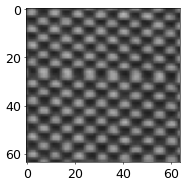

tf.Tensor(
[[[ 87.  87.  87.]
  [119. 119. 119.]
  [133. 133. 133.]
  ...
  [ 63.  63.  63.]
  [105. 105. 105.]
  [139. 139. 139.]]

 [[110. 110. 110.]
  [151. 151. 151.]
  [159. 159. 159.]
  ...
  [ 66.  66.  66.]
  [ 91.  91.  91.]
  [106. 106. 106.]]

 [[115. 115. 115.]
  [148. 148. 148.]
  [154. 154. 154.]
  ...
  [ 71.  71.  71.]
  [ 51.  51.  51.]
  [ 39.  39.  39.]]

 ...

 [[ 84.  84.  84.]
  [131. 131. 131.]
  [151. 151. 151.]
  ...
  [103. 103. 103.]
  [ 76.  76.  76.]
  [ 49.  49.  49.]]

 [[ 62.  62.  62.]
  [ 68.  68.  68.]
  [ 72.  72.  72.]
  ...
  [142. 142. 142.]
  [104. 104. 104.]
  [ 52.  52.  52.]]

 [[ 71.  71.  71.]
  [ 45.  45.  45.]
  [ 39.  39.  39.]
  ...
  [142. 142. 142.]
  [111. 111. 111.]
  [ 63.  63.  63.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


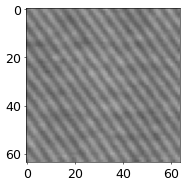

tf.Tensor(
[[[112. 112. 112.]
  [134. 134. 134.]
  [155. 155. 155.]
  ...
  [118. 118. 118.]
  [109. 109. 109.]
  [135. 135. 135.]]

 [[111. 111. 111.]
  [109. 109. 109.]
  [136. 136. 136.]
  ...
  [129. 129. 129.]
  [109. 109. 109.]
  [119. 119. 119.]]

 [[127. 127. 127.]
  [111. 111. 111.]
  [113. 113. 113.]
  ...
  [144. 144. 144.]
  [113. 113. 113.]
  [101. 101. 101.]]

 ...

 [[142. 142. 142.]
  [140. 140. 140.]
  [114. 114. 114.]
  ...
  [143. 143. 143.]
  [160. 160. 160.]
  [128. 128. 128.]]

 [[131. 131. 131.]
  [150. 150. 150.]
  [137. 137. 137.]
  ...
  [134. 134. 134.]
  [154. 154. 154.]
  [157. 157. 157.]]

 [[106. 106. 106.]
  [142. 142. 142.]
  [149. 149. 149.]
  ...
  [104. 104. 104.]
  [135. 135. 135.]
  [150. 150. 150.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


In [369]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi']     = 50

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(0, len(images)):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.show()
        print(images[i])
        print(labels[i])
        print("-----------------------------")
    

In [370]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [371]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])



In [372]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_45 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 16, 16, 64)      

In [373]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

Epoch 1/15
159/159 [==============================] - 29s 141ms/step - loss: 0.5238 - accuracy: 0.7538 - val_loss: 0.4064 - val_accuracy: 0.7797
Epoch 2/15
159/159 [==============================] - 22s 138ms/step - loss: 0.4780 - accuracy: 0.7709 - val_loss: 0.3448 - val_accuracy: 0.8170
Epoch 3/15
159/159 [==============================] - 22s 140ms/step - loss: 0.4293 - accuracy: 0.7729 - val_loss: 0.3332 - val_accuracy: 0.7973
Epoch 4/15
159/159 [==============================] - 24s 152ms/step - loss: 0.3921 - accuracy: 0.7917 - val_loss: 0.2837 - val_accuracy: 0.8387
Epoch 5/15
159/159 [==============================] - 26s 163ms/step - loss: 0.3236 - accuracy: 0.8600 - val_loss: 0.2097 - val_accuracy: 0.9297
Epoch 6/15
159/159 [==============================] - 27s 167ms/step - loss: 0.1898 - accuracy: 0.9336 - val_loss: 0.1119 - val_accuracy: 0.9679
Epoch 7/15
159/159 [==============================] - 29s 180ms/step - loss: 0.1228 - accuracy: 0.9629 - val_loss: 0.0930 - val_ac

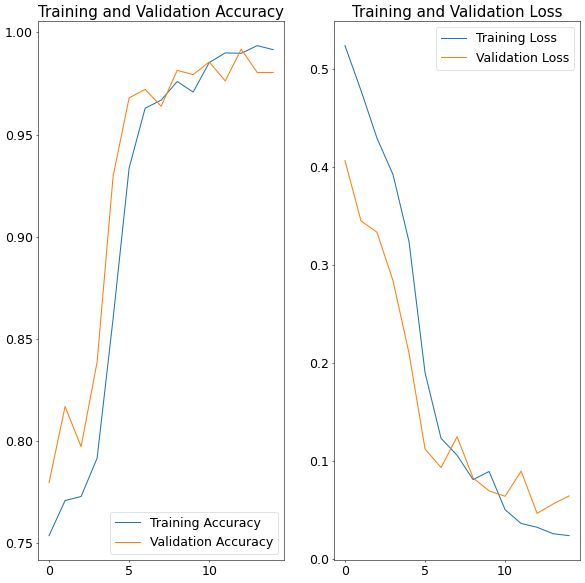

In [374]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [375]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

18/18 [==============================] - 2s 93ms/step - loss: 0.0772 - accuracy: 0.9876


{'loss': 0.07723772525787354, 'accuracy': 0.98758864402771}

In [376]:
# cwd = os.getcwd()
model.save("inspection_model")

#model.save_weights("inspection_weights")

INFO:tensorflow:Assets written to: inspection_model\assets


In [377]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
  ]
)

In [378]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
#   layers.Dense(1)
])



In [379]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 sequential_24 (Sequential)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_48 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                

In [380]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

Epoch 1/15
159/159 [==============================] - 34s 200ms/step - loss: 0.5251 - accuracy: 0.7565 - val_loss: 0.4996 - val_accuracy: 0.7642
Epoch 2/15
159/159 [==============================] - 31s 195ms/step - loss: 0.4980 - accuracy: 0.7648 - val_loss: 0.3913 - val_accuracy: 0.8087
Epoch 3/15
159/159 [==============================] - 30s 188ms/step - loss: 0.5001 - accuracy: 0.7634 - val_loss: 0.4886 - val_accuracy: 0.7746
Epoch 4/15
159/159 [==============================] - 28s 177ms/step - loss: 0.4915 - accuracy: 0.7761 - val_loss: 0.4146 - val_accuracy: 0.7797
Epoch 5/15
159/159 [==============================] - 25s 159ms/step - loss: 0.4810 - accuracy: 0.7721 - val_loss: 0.4243 - val_accuracy: 0.7859
Epoch 6/15
159/159 [==============================] - 33s 208ms/step - loss: 0.4642 - accuracy: 0.7699 - val_loss: 0.3754 - val_accuracy: 0.8077
Epoch 7/15
159/159 [==============================] - 39s 244ms/step - loss: 0.4031 - accuracy: 0.8083 - val_loss: 0.3429 - val_ac

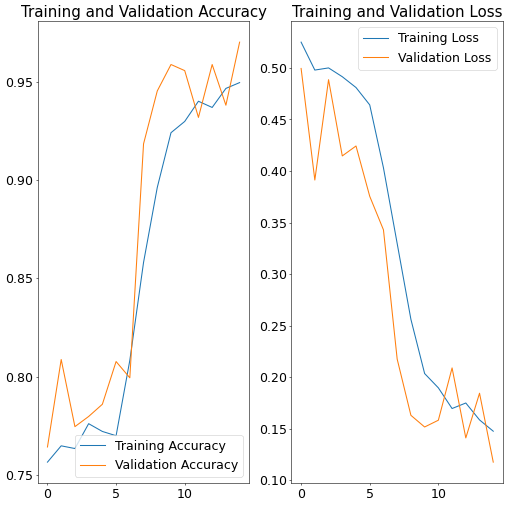

In [381]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [382]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

Epoch 1/15
159/159 [==============================] - 40s 254ms/step - loss: 0.1342 - accuracy: 0.9562 - val_loss: 0.1175 - val_accuracy: 0.9700
Epoch 2/15
159/159 [==============================] - 39s 246ms/step - loss: 0.1302 - accuracy: 0.9593 - val_loss: 0.1095 - val_accuracy: 0.9690
Epoch 3/15
159/159 [==============================] - 39s 244ms/step - loss: 0.1340 - accuracy: 0.9548 - val_loss: 0.0891 - val_accuracy: 0.9762
Epoch 4/15
159/159 [==============================] - 38s 237ms/step - loss: 0.1178 - accuracy: 0.9619 - val_loss: 0.0898 - val_accuracy: 0.9772
Epoch 5/15
159/159 [==============================] - 38s 240ms/step - loss: 0.1167 - accuracy: 0.9609 - val_loss: 0.0987 - val_accuracy: 0.9762
Epoch 6/15
159/159 [==============================] - 40s 249ms/step - loss: 0.1043 - accuracy: 0.9652 - val_loss: 0.1310 - val_accuracy: 0.9710
Epoch 7/15
159/159 [==============================] - 26s 163ms/step - loss: 0.1072 - accuracy: 0.9660 - val_loss: 0.1962 - val_ac

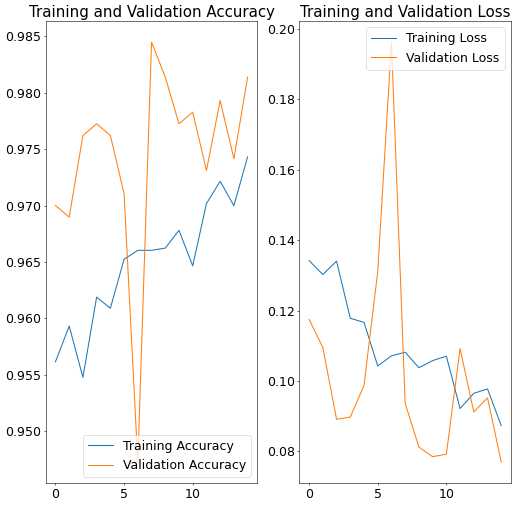

In [383]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [384]:
model.save("inspection_model_aug")


INFO:tensorflow:Assets written to: inspection_model_aug\assets


In [385]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

18/18 [==============================] - 2s 94ms/step - loss: 0.0760 - accuracy: 0.9840


{'loss': 0.07598987966775894, 'accuracy': 0.9840425252914429}

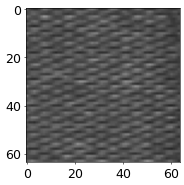

CNN output: [[0.84279]]
This image most likely belongs to normal with a 84.28 percent confidence.
inference took: 0.3138418000016827 ms


In [386]:
path = "./test_data/defect/defect_0.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)
print("inference took:", timeTaken,"ms")

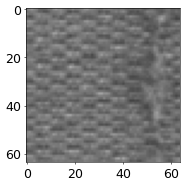

CNN output: [[0.05674779]]
This image most likely belongs to defect with a 94.33 percent confidence.
inference took: 0.1119845999928657 ms


In [387]:
path = "./test_data/defect/defect_1.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

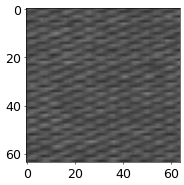

CNN output: [[0.9972362]]
This image most likely belongs to normal with a 99.72 percent confidence.
inference took: 0.19080749998101965 ms


In [388]:
path = "./test_data/normal/normal_0.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

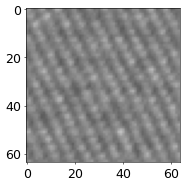

CNN output: [[0.99636555]]
This image most likely belongs to normal with a 99.64 percent confidence.
inference took: 0.11084419998223893 ms


In [389]:
path = "./test_data/normal/normal_1.png"


cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

In [390]:
# dad got an accarcy of 93% on inspections machines without ai

# More Testing without data augmentation

In [391]:
# loading 


reconstructed_model = keras.models.load_model("inspection_model")


In [392]:

result = reconstructed_model.evaluate(test_ds)

dict(zip(reconstructed_model.metrics_names, result))

18/18 [==============================] - 2s 90ms/step - loss: 0.0772 - accuracy: 0.9876


{'loss': 0.07723771780729294, 'accuracy': 0.98758864402771}

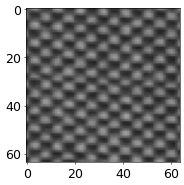

CNN output: [[0.01694742]]
This image most likely belongs to defect with a 98.31 percent confidence.
inference took: 0.2536903999862261 ms


In [393]:
path = "./test_data/defect/defect_20.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()
predictions = reconstructed_model.predict(img_array)
timeTaken = time.perf_counter() - start

# score = tf.nn.sigmoid(predictions[0])

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

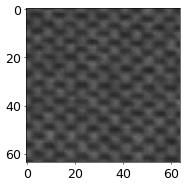

CNN output: [[0.9995103]]
This image most likely belongs to normal with a 99.95 percent confidence.
inference took: 0.10960630001500249 ms


In [394]:
path = "./tiles/normal/0001_000_00_7.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()
predictions = reconstructed_model.predict(img_array)
timeTaken = time.perf_counter() - start

# score = tf.nn.sigmoid(predictions[0])

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

Have to change batchsize to properly inspect, not needed if data isnt shuffled

In [395]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=1,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 564 files belonging to 2 classes.


In [396]:
model = reconstructed_model

preds = model.predict(test_ds,batch_size = 1,
verbose=1)

individualPredicts = []

TP = 0
TN = 0
FP = 0
FN = 0

names = os.listdir("./test_data/defect/")
for name in names:
    path = "./test_data/defect/"+name
    img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
    )
                   
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    p_class = int(np.rint(predictions[0]))
    individualPredicts.append(p_class)
    
    if p_class == 0:
        TP = TP + 1
    else:
        FP = FP + 1
        
    
    
    
names = os.listdir("./test_data/normal/")
for name in names:
    path = "./test_data/normal/"+name
    img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
    )
                   
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    p_class = int(np.rint(predictions[0]))
    individualPredicts.append(p_class)
    
    if p_class == 1:
        TN = TN + 1
    else:
        FN = FN + 1


# print(preds)
# print(individualPredicts)
print(TP, FP)
print(FN, TN)



564/564 [==============================] - 7s 12ms/step
85 3
4 472


In [397]:
predictions = []
targets  = []

start = time.perf_counter()

for image, target in test_ds:
    prediction = model.predict(image)
    targets.append(tf.get_static_value(target)[0][0])
    predictions.append(int(np.rint(prediction[0])))
    
taken = time.perf_counter() - start

print("time using single prediction:", taken)



time using single prediction: 84.19393979999586


[[ 85   3]
 [  4 472]]


<Figure size 1000x500 with 0 Axes>

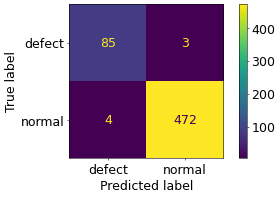

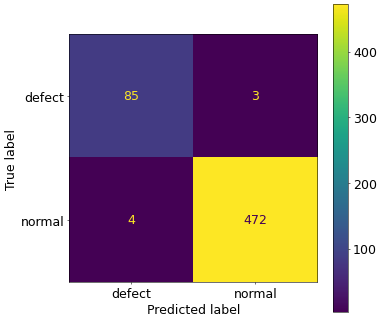

In [399]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targets, predictions)
print(cm)

plt.figure(figsize=(20,10)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

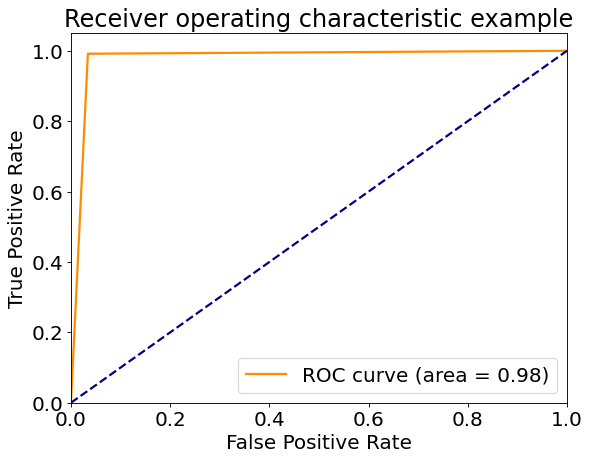

In [400]:
# y = np.concatenate([y for x, y in test_ds], axis=0)
# print(y)


fpr, tpr, _ = metrics.roc_curve(targets, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [401]:
from sklearn.metrics import classification_report
 

print(classification_report(targets, predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96        88
         1.0       0.99      0.99      0.99       476

    accuracy                           0.99       564
   macro avg       0.97      0.98      0.98       564
weighted avg       0.99      0.99      0.99       564



In [402]:

result = reconstructed_model.evaluate(all_ds)

dict(zip(reconstructed_model.metrics_names, result))

3570/3570 [==============================] - 365s 102ms/step - loss: 0.0305 - accuracy: 0.9918


{'loss': 0.0304750707000494, 'accuracy': 0.9918400049209595}

In [403]:
all_ds = keras.utils.image_dataset_from_directory(
    directory='tiles/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 114216 files belonging to 2 classes.


In [404]:
predictions = reconstructed_model.predict(all_ds)


roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))

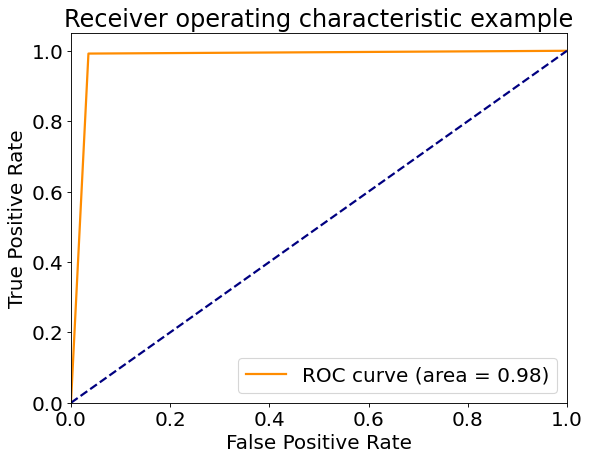

In [405]:
targets = np.concatenate([targets for features, targets in all_ds], axis=0)

fpr, tpr, _ = metrics.roc_curve(targets, roundedPredictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<Figure size 1000x500 with 0 Axes>

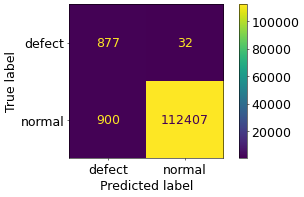

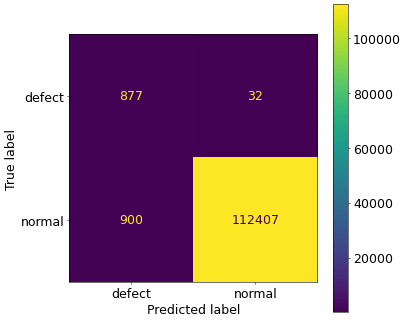

In [406]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

targets = np.concatenate([targets for features, targets in all_ds], axis=0)


cm = confusion_matrix(targets, roundedPredictions)
#print(cm)

#print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))

plt.figure(figsize=(20,10)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

# With Data Augmetation

In [407]:
reconstructed_model = keras.models.load_model("inspection_model_aug")


In [408]:
result = reconstructed_model.evaluate(all_ds)

dict(zip(reconstructed_model.metrics_names, result))

3570/3570 [==============================] - 315s 88ms/step - loss: 0.0434 - accuracy: 0.9900


{'loss': 0.04341668635606766, 'accuracy': 0.990010142326355}

In [409]:
predictions = reconstructed_model.predict(all_ds)


roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))

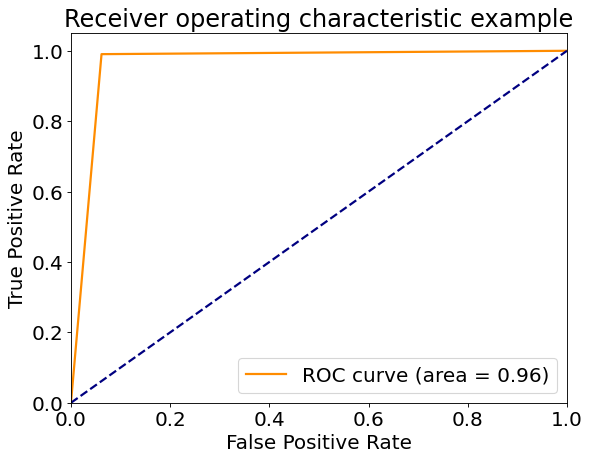

In [410]:
targets = np.concatenate([targets for features, targets in all_ds], axis=0)

fpr, tpr, _ = metrics.roc_curve(targets, roundedPredictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [411]:
# print(classification_report(targets, predictions))

In [412]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

targets = np.concatenate([targets for features, targets in all_ds], axis=0)


cm = confusion_matrix(targets, roundedPredictions)
print(cm)

print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))



[[   853     56]
 [  1085 112222]]
0.9575754366455737


<Figure size 1000x500 with 0 Axes>

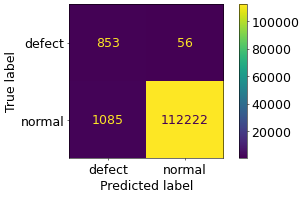

In [413]:
plt.figure(figsize=(20,10)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()

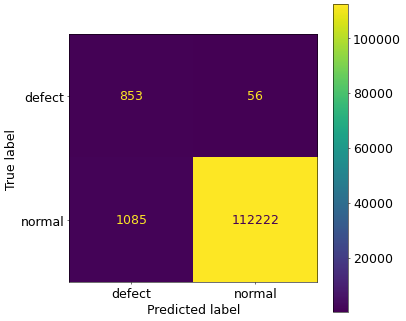

In [414]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

# With confidence 0.05 cutoff

In [415]:
predictions = reconstructed_model.predict(all_ds)

print("predictions done")



predictions done


In [416]:
roundedPredictions = []
for p in predictions:
    p_temp = 0
    if p[0] > 0.02:
        p_temp = 1
    roundedPredictions.append(p_temp)

[[   705    204]
 [   181 113126]]
0.15974299910861642


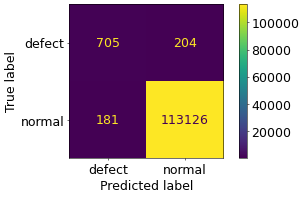

In [417]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

targets = np.concatenate([targets for features, targets in all_ds], axis=0)


cm = confusion_matrix(targets, roundedPredictions)
print(cm)

print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_ds.class_names)
disp.plot()
plt.show()

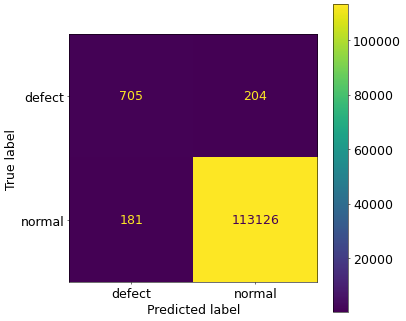

In [418]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

shuffel Off

In [419]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 564 files belonging to 2 classes.


In [420]:

start = time.perf_counter()
predictions = reconstructed_model.predict(test_ds)


roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))
    
taken = time.perf_counter() - start

print("time taken using batch prediction:", taken)


time taken using batch prediction: 1.3559572999947704


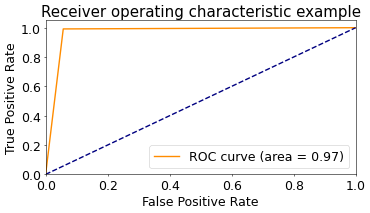

In [421]:
targets = np.concatenate([targets for features, targets in test_ds], axis=0)

fpr, tpr, _ = metrics.roc_curve(targets, roundedPredictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[ 83   5]
 [  4 472]]


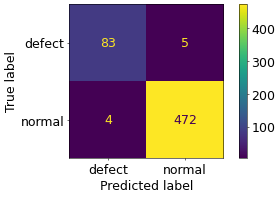

In [422]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(targets, roundedPredictions)
print(cm)



disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()

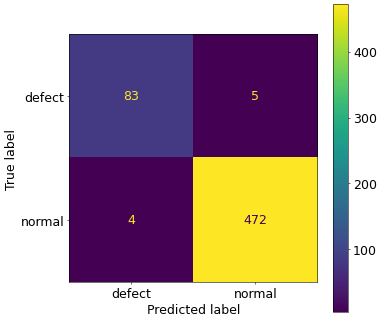

In [423]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

Checking opencv conversion

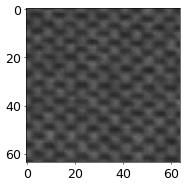

CNN output: [[0.9915992]]
This image most likely belongs to normal with a 99.16 percent confidence.
TensorFlow image prediction:  0.9915992
OpenCv image prediction:  0.9915992


In [424]:
path = "./tiles/normal/0001_000_00_7.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = reconstructed_model.predict(img_array)


p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("TensorFlow image prediction: ", predictions[0][0])


tileImRGB = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
tensor = tf.convert_to_tensor(tileImRGB, dtype=tf.float32)
tensor = tf.expand_dims(tensor, 0)

predictions = reconstructed_model.predict(tensor)
print("OpenCv image prediction: ", predictions[0][0])



In [425]:
model = keras.models.load_model("inspection_model")


In [426]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_45 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 16, 16, 64)      

In [427]:
for layer in model.layers:
    print(len(layer.get_weights()))

0
2
0
2
0
2
0
0
2
2
2


C:\Users\schof\AppData\Local\Temp\ipykernel_17468\2743335361.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cw1 = np.array(model.layers[1].get_weights())
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


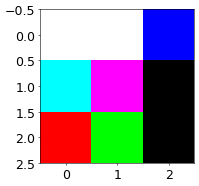

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


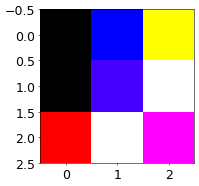

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


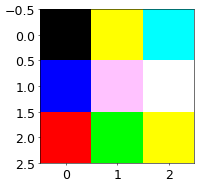

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


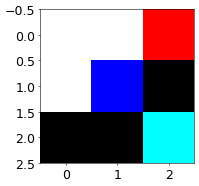

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


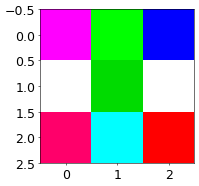

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


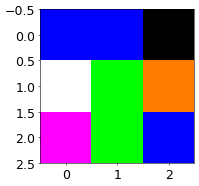

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


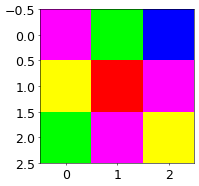

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


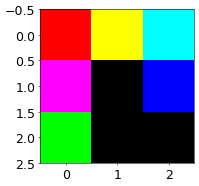

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


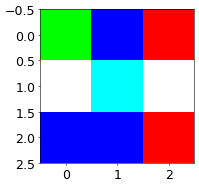

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


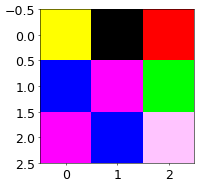

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


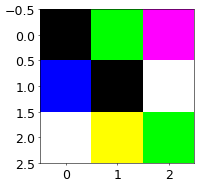

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


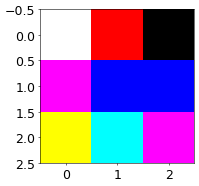

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


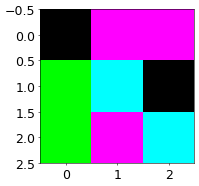

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


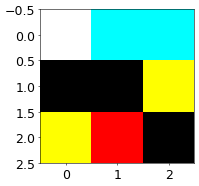

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


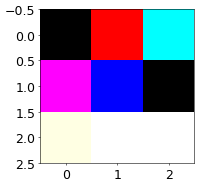

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


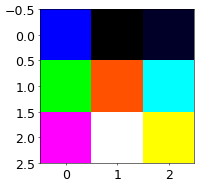

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


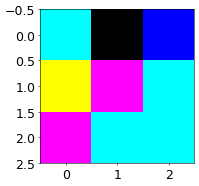

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


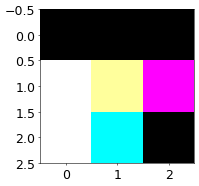

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


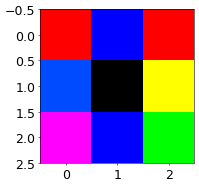

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


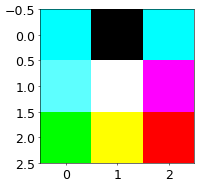

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


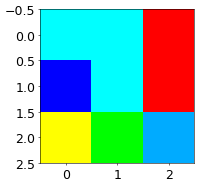

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


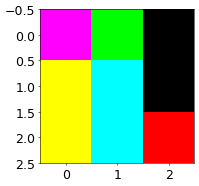

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


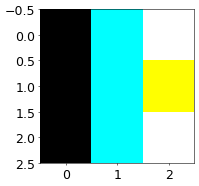

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


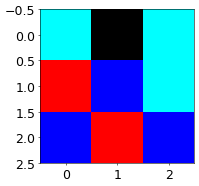

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


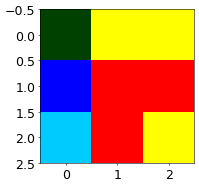

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


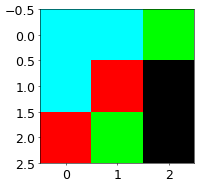

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


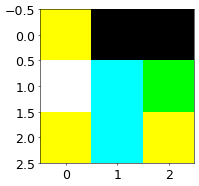

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


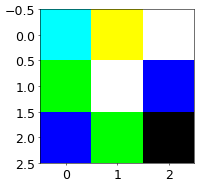

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


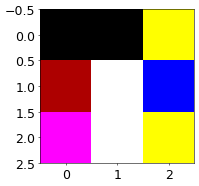

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


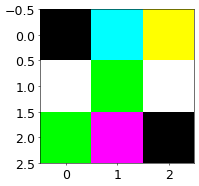

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


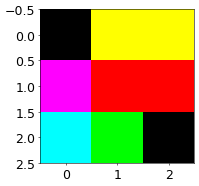

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


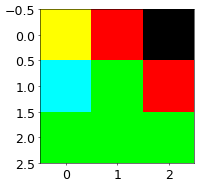

In [428]:
cw1 = np.array(model.layers[1].get_weights())
for i in range(32):
    plt.imshow(cw1[0][:,:,:,i]*255)
    plt.show()